In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

In [3]:
import keras
from keras_unet.models import custom_unet


2023-01-08 22:44:12.605308: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [4]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [5]:
images = np.load(images_file)
labels = np.load(labels_file)

In [6]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [7]:
p = np.random.permutation(len(images))

In [8]:
images = images[p]
labels = labels[p]

In [9]:
labels = labels.astype(np.float64)

In [10]:
images = images.astype(np.float64)

for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [11]:
images.shape

(503, 512, 512, 1)

In [12]:
X_train = images[0:300]
y_train = labels[0:300]
X_val = images[300:400]
y_val = labels[300:400]
X_test = images[400:]
y_test = labels[400:]

In [13]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 512, 512, 1) (2, 512, 512, 1)


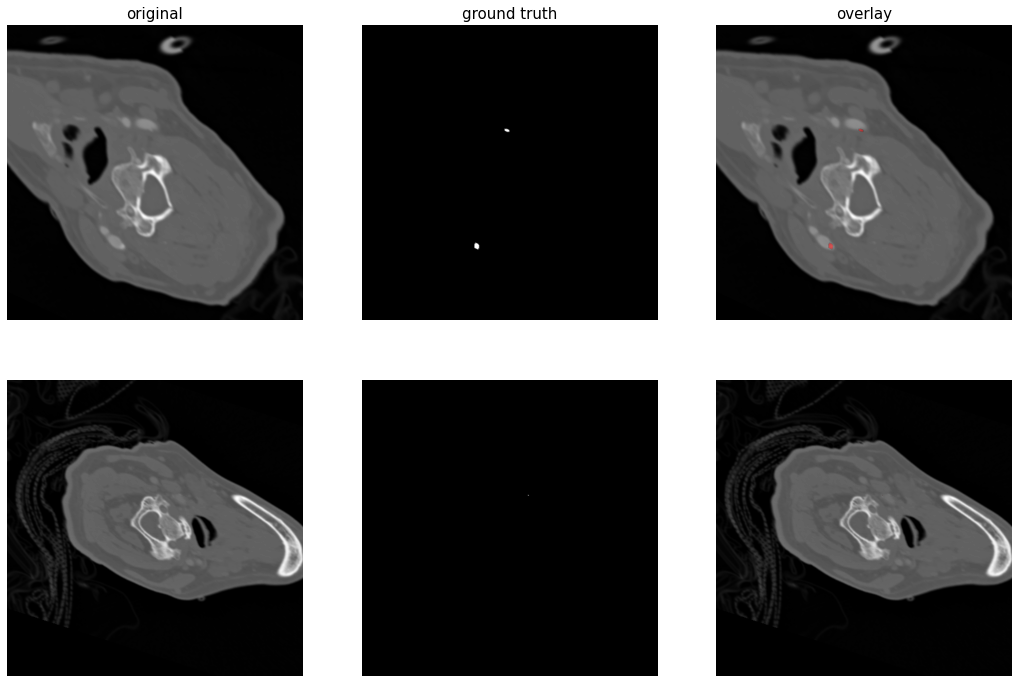

In [14]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [15]:

model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.5,
    output_activation='sigmoid')

2023-01-08 22:44:22.172618: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-01-08 22:44:22.299328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-01-08 22:44:22.299370: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-01-08 22:44:22.302409: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-08 22:44:22.302442: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-01-08 22:44:22.303289: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 512, 512, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       spatial_dropout2d[0][0]          
______________________________________________________________________________________________

In [17]:
from tensorflow import keras
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

In [18]:
from keras.callbacks import EarlyStopping

earlystopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=30,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

In [19]:

from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

In [20]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [21]:
model.compile(optimizer = opt,    
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [39]:
history = model.fit(X_train, 
                    y_train, 
                    32, 
                    epochs=600,
                    validation_data=(X_val, y_val),)
#                     callbacks = [earlystopping])

Epoch 1/600
10/10 [==============================] - 10s 963ms/step - loss: 1.9423e-04 - iou: 0.6097 - iou_thresholded: 0.7106 - val_loss: 3.4490e-04 - val_iou: 0.4401 - val_iou_thresholded: 0.5434
Epoch 2/600
10/10 [==============================] - 10s 950ms/step - loss: 1.9672e-04 - iou: 0.5967 - iou_thresholded: 0.7036 - val_loss: 3.6696e-04 - val_iou: 0.4395 - val_iou_thresholded: 0.5152
Epoch 3/600
10/10 [==============================] - 10s 952ms/step - loss: 1.9023e-04 - iou: 0.6150 - iou_thresholded: 0.7201 - val_loss: 3.5341e-04 - val_iou: 0.4605 - val_iou_thresholded: 0.5441
Epoch 4/600
10/10 [==============================] - 10s 952ms/step - loss: 1.8521e-04 - iou: 0.6268 - iou_thresholded: 0.7260 - val_loss: 3.6531e-04 - val_iou: 0.4620 - val_iou_thresholded: 0.5340
Epoch 5/600
10/10 [==============================] - 10s 951ms/step - loss: 1.9245e-04 - iou: 0.6203 - iou_thresholded: 0.7190 - val_loss: 3.5726e-04 - val_iou: 0.4361 - val_iou_thresholded: 0.5334
Epoch 6/60

10/10 [==============================] - 10s 953ms/step - loss: 1.6162e-04 - iou: 0.6688 - iou_thresholded: 0.7529 - val_loss: 3.6875e-04 - val_iou: 0.4679 - val_iou_thresholded: 0.5395
Epoch 43/600
10/10 [==============================] - 10s 953ms/step - loss: 1.6289e-04 - iou: 0.6667 - iou_thresholded: 0.7560 - val_loss: 3.8987e-04 - val_iou: 0.4591 - val_iou_thresholded: 0.5127
Epoch 44/600
10/10 [==============================] - 10s 953ms/step - loss: 1.5756e-04 - iou: 0.6698 - iou_thresholded: 0.7590 - val_loss: 3.6758e-04 - val_iou: 0.4849 - val_iou_thresholded: 0.5428
Epoch 45/600
10/10 [==============================] - 10s 963ms/step - loss: 1.5573e-04 - iou: 0.6735 - iou_thresholded: 0.7629 - val_loss: 3.6152e-04 - val_iou: 0.4682 - val_iou_thresholded: 0.5426
Epoch 46/600
10/10 [==============================] - 10s 953ms/step - loss: 1.5637e-04 - iou: 0.6755 - iou_thresholded: 0.7628 - val_loss: 3.5959e-04 - val_iou: 0.4851 - val_iou_thresholded: 0.5538
Epoch 47/600
10/10

10/10 [==============================] - 10s 956ms/step - loss: 1.3310e-04 - iou: 0.7237 - iou_thresholded: 0.8029 - val_loss: 3.8568e-04 - val_iou: 0.4695 - val_iou_thresholded: 0.5466
Epoch 84/600
10/10 [==============================] - 10s 954ms/step - loss: 1.3216e-04 - iou: 0.7224 - iou_thresholded: 0.8002 - val_loss: 4.1156e-04 - val_iou: 0.4902 - val_iou_thresholded: 0.5357
Epoch 85/600
10/10 [==============================] - 10s 956ms/step - loss: 1.2262e-04 - iou: 0.7271 - iou_thresholded: 0.8113 - val_loss: 4.0204e-04 - val_iou: 0.4949 - val_iou_thresholded: 0.5474
Epoch 86/600
10/10 [==============================] - 10s 964ms/step - loss: 1.2777e-04 - iou: 0.7224 - iou_thresholded: 0.8009 - val_loss: 3.9983e-04 - val_iou: 0.4940 - val_iou_thresholded: 0.5458
Epoch 87/600
10/10 [==============================] - 10s 958ms/step - loss: 1.3050e-04 - iou: 0.7236 - iou_thresholded: 0.8036 - val_loss: 3.8817e-04 - val_iou: 0.4840 - val_iou_thresholded: 0.5461
Epoch 88/600
10/10

10/10 [==============================] - 10s 957ms/step - loss: 1.0272e-04 - iou: 0.7745 - iou_thresholded: 0.8438 - val_loss: 4.3416e-04 - val_iou: 0.4985 - val_iou_thresholded: 0.5417
Epoch 125/600
10/10 [==============================] - 10s 954ms/step - loss: 9.8763e-05 - iou: 0.7760 - iou_thresholded: 0.8475 - val_loss: 4.4825e-04 - val_iou: 0.5026 - val_iou_thresholded: 0.5458
Epoch 126/600
10/10 [==============================] - 10s 955ms/step - loss: 1.0032e-04 - iou: 0.7770 - iou_thresholded: 0.8437 - val_loss: 4.2469e-04 - val_iou: 0.5033 - val_iou_thresholded: 0.5501
Epoch 127/600
10/10 [==============================] - 10s 963ms/step - loss: 1.0552e-04 - iou: 0.7704 - iou_thresholded: 0.8411 - val_loss: 4.2909e-04 - val_iou: 0.5106 - val_iou_thresholded: 0.5585
Epoch 128/600
10/10 [==============================] - 10s 960ms/step - loss: 1.0067e-04 - iou: 0.7742 - iou_thresholded: 0.8470 - val_loss: 4.5063e-04 - val_iou: 0.4906 - val_iou_thresholded: 0.5317
Epoch 129/600


10/10 [==============================] - 10s 959ms/step - loss: 7.0002e-05 - iou: 0.8331 - iou_thresholded: 0.8907 - val_loss: 5.0506e-04 - val_iou: 0.5081 - val_iou_thresholded: 0.5438
Epoch 166/600
10/10 [==============================] - 10s 954ms/step - loss: 7.7882e-05 - iou: 0.8288 - iou_thresholded: 0.8837 - val_loss: 4.9168e-04 - val_iou: 0.5096 - val_iou_thresholded: 0.5450
Epoch 167/600
10/10 [==============================] - 10s 955ms/step - loss: 7.3274e-05 - iou: 0.8285 - iou_thresholded: 0.8867 - val_loss: 5.1466e-04 - val_iou: 0.5008 - val_iou_thresholded: 0.5323
Epoch 168/600
10/10 [==============================] - 10s 964ms/step - loss: 7.1646e-05 - iou: 0.8306 - iou_thresholded: 0.8894 - val_loss: 4.9396e-04 - val_iou: 0.5172 - val_iou_thresholded: 0.5525
Epoch 169/600
10/10 [==============================] - 10s 956ms/step - loss: 8.3689e-05 - iou: 0.8335 - iou_thresholded: 0.8887 - val_loss: 4.9283e-04 - val_iou: 0.4840 - val_iou_thresholded: 0.5343
Epoch 170/600


10/10 [==============================] - 10s 956ms/step - loss: 6.2188e-05 - iou: 0.8643 - iou_thresholded: 0.9127 - val_loss: 5.1853e-04 - val_iou: 0.5303 - val_iou_thresholded: 0.5560
Epoch 207/600
10/10 [==============================] - 10s 955ms/step - loss: 6.2550e-05 - iou: 0.8579 - iou_thresholded: 0.9105 - val_loss: 4.9634e-04 - val_iou: 0.5180 - val_iou_thresholded: 0.5480
Epoch 208/600
10/10 [==============================] - 10s 955ms/step - loss: 5.9447e-05 - iou: 0.8571 - iou_thresholded: 0.9106 - val_loss: 5.6201e-04 - val_iou: 0.5138 - val_iou_thresholded: 0.5390
Epoch 209/600
10/10 [==============================] - 10s 963ms/step - loss: 5.6180e-05 - iou: 0.8695 - iou_thresholded: 0.9164 - val_loss: 5.6369e-04 - val_iou: 0.5114 - val_iou_thresholded: 0.5393
Epoch 210/600
10/10 [==============================] - 10s 957ms/step - loss: 5.5636e-05 - iou: 0.8706 - iou_thresholded: 0.9179 - val_loss: 5.7247e-04 - val_iou: 0.5265 - val_iou_thresholded: 0.5542
Epoch 211/600


10/10 [==============================] - 10s 956ms/step - loss: 5.1574e-05 - iou: 0.8808 - iou_thresholded: 0.9243 - val_loss: 5.8705e-04 - val_iou: 0.5049 - val_iou_thresholded: 0.5334
Epoch 248/600
10/10 [==============================] - 10s 955ms/step - loss: 6.1451e-05 - iou: 0.8704 - iou_thresholded: 0.9115 - val_loss: 6.0678e-04 - val_iou: 0.5061 - val_iou_thresholded: 0.5265
Epoch 249/600
10/10 [==============================] - 10s 955ms/step - loss: 7.9171e-05 - iou: 0.8373 - iou_thresholded: 0.8884 - val_loss: 4.9616e-04 - val_iou: 0.4996 - val_iou_thresholded: 0.5377
Epoch 250/600
10/10 [==============================] - 10s 966ms/step - loss: 8.7169e-05 - iou: 0.8263 - iou_thresholded: 0.8836 - val_loss: 5.1320e-04 - val_iou: 0.4991 - val_iou_thresholded: 0.5217
Epoch 251/600
10/10 [==============================] - 10s 958ms/step - loss: 7.6816e-05 - iou: 0.8300 - iou_thresholded: 0.8880 - val_loss: 4.9998e-04 - val_iou: 0.4650 - val_iou_thresholded: 0.5249
Epoch 252/600


KeyboardInterrupt: 

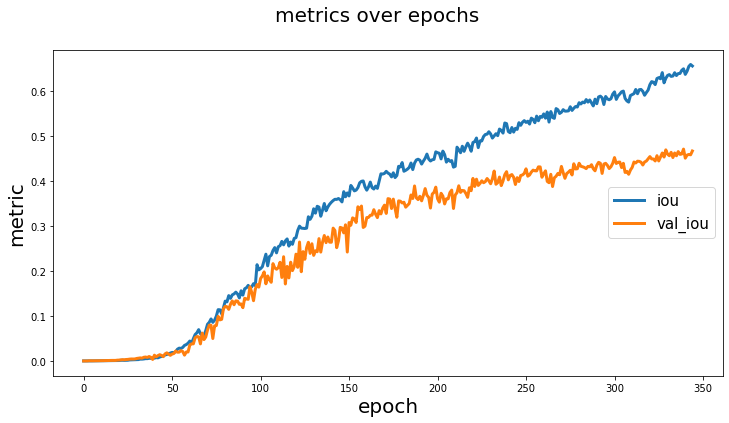

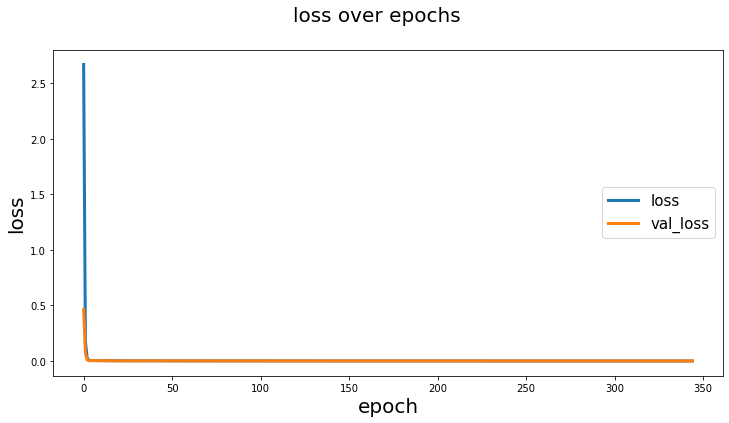

In [40]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [41]:
y_pred = model.predict(X_test)

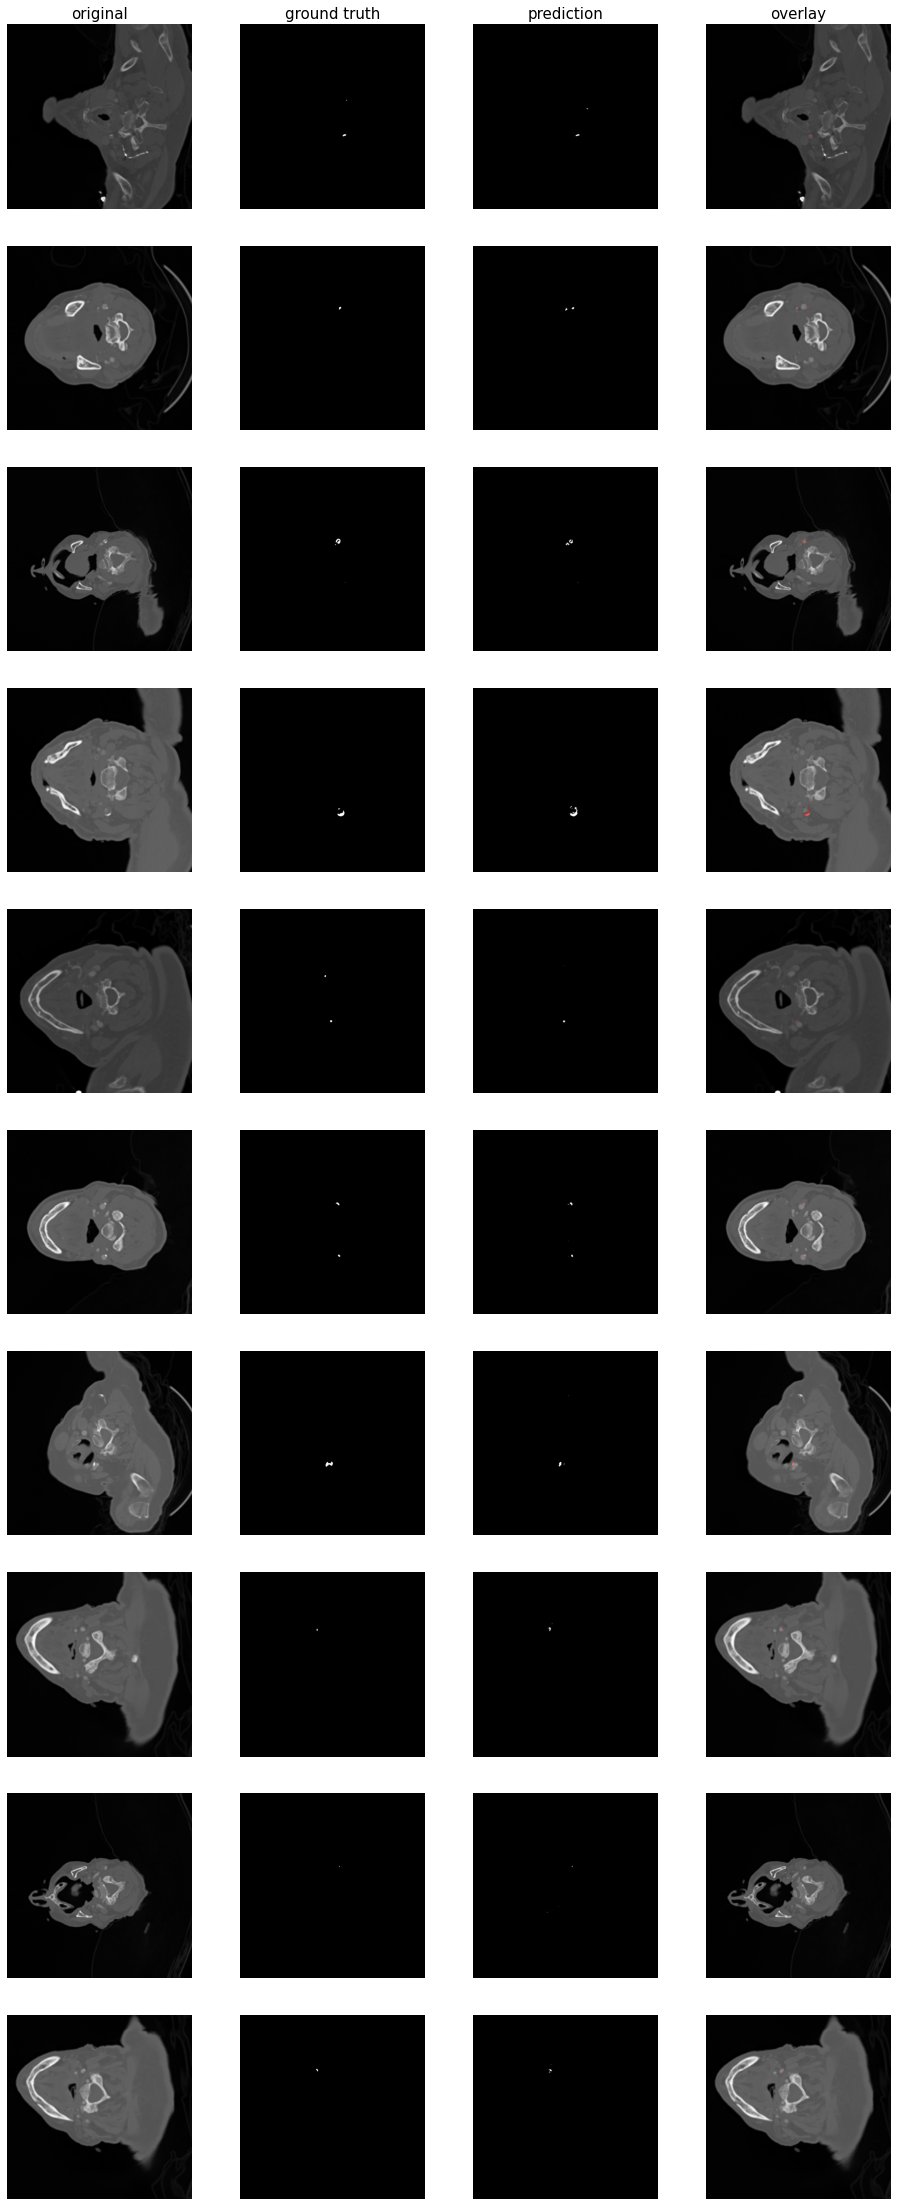

In [42]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)

In [43]:
loss, iou, iou_thresholded = model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 161ms/step - loss: 7.2991e-04 - iou: 0.4708 - iou_thresholded: 0.4994


In [27]:
import mahotas as mh

In [28]:
image = X_test[0]

In [29]:
image.shape

(512, 512, 1)

In [30]:
label = y_test[0]

In [31]:
pred = y_pred[0]

In [32]:
bbox = mh.bbox(label)
incr=30

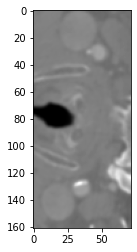

In [33]:
imshow(image[bbox[0]-incr:bbox[1]+incr,bbox[2]-incr:bbox[3]+incr,:],cmap='gray')

In [34]:
X_test_c = []
y_test_c = []
y_pred_c = []

for i,z in enumerate(X_test):
    
    image = X_test[i]
    label = y_test[i]
    pred = y_pred[i]
    
    bbox = mh.bbox(label)
    incr=30
    X_test_c.append(image[bbox[0]-incr:bbox[1]+incr,bbox[2]-incr:bbox[3]+incr,:])
    y_test_c.append(label[bbox[0]-incr:bbox[1]+incr,bbox[2]-incr:bbox[3]+incr,:])
    y_pred_c.append(pred[bbox[0]-incr:bbox[1]+incr,bbox[2]-incr:bbox[3]+incr,:])


In [35]:
maxX = 0
maxY = 0

for i,z in enumerate(X_test_c):
    
    maxX = max(z.shape[1], maxX)
    maxY = max(z.shape[0], maxY)
    
X_test_c_np = np.zeros((len(X_test_c), maxY, maxX,1), dtype=X_test.dtype)
y_test_c_np = np.zeros((len(y_test_c), maxY, maxX,1), dtype=y_test.dtype)
y_pred_c_np = np.zeros((len(y_pred_c), maxY, maxX,1), dtype=y_pred.dtype)

for i,z in enumerate(X_test_c):
    
    image = X_test_c[i]
    label = y_test_c[i]
    pred = y_pred_c[i]
    
    X_test_c_np[i][0:image.shape[0], 0:image.shape[1],:] = image
    y_test_c_np[i][0:label.shape[0], 0:label.shape[1],:] = label
    y_pred_c_np[i][0:pred.shape[0], 0:pred.shape[1],:] = pred
    

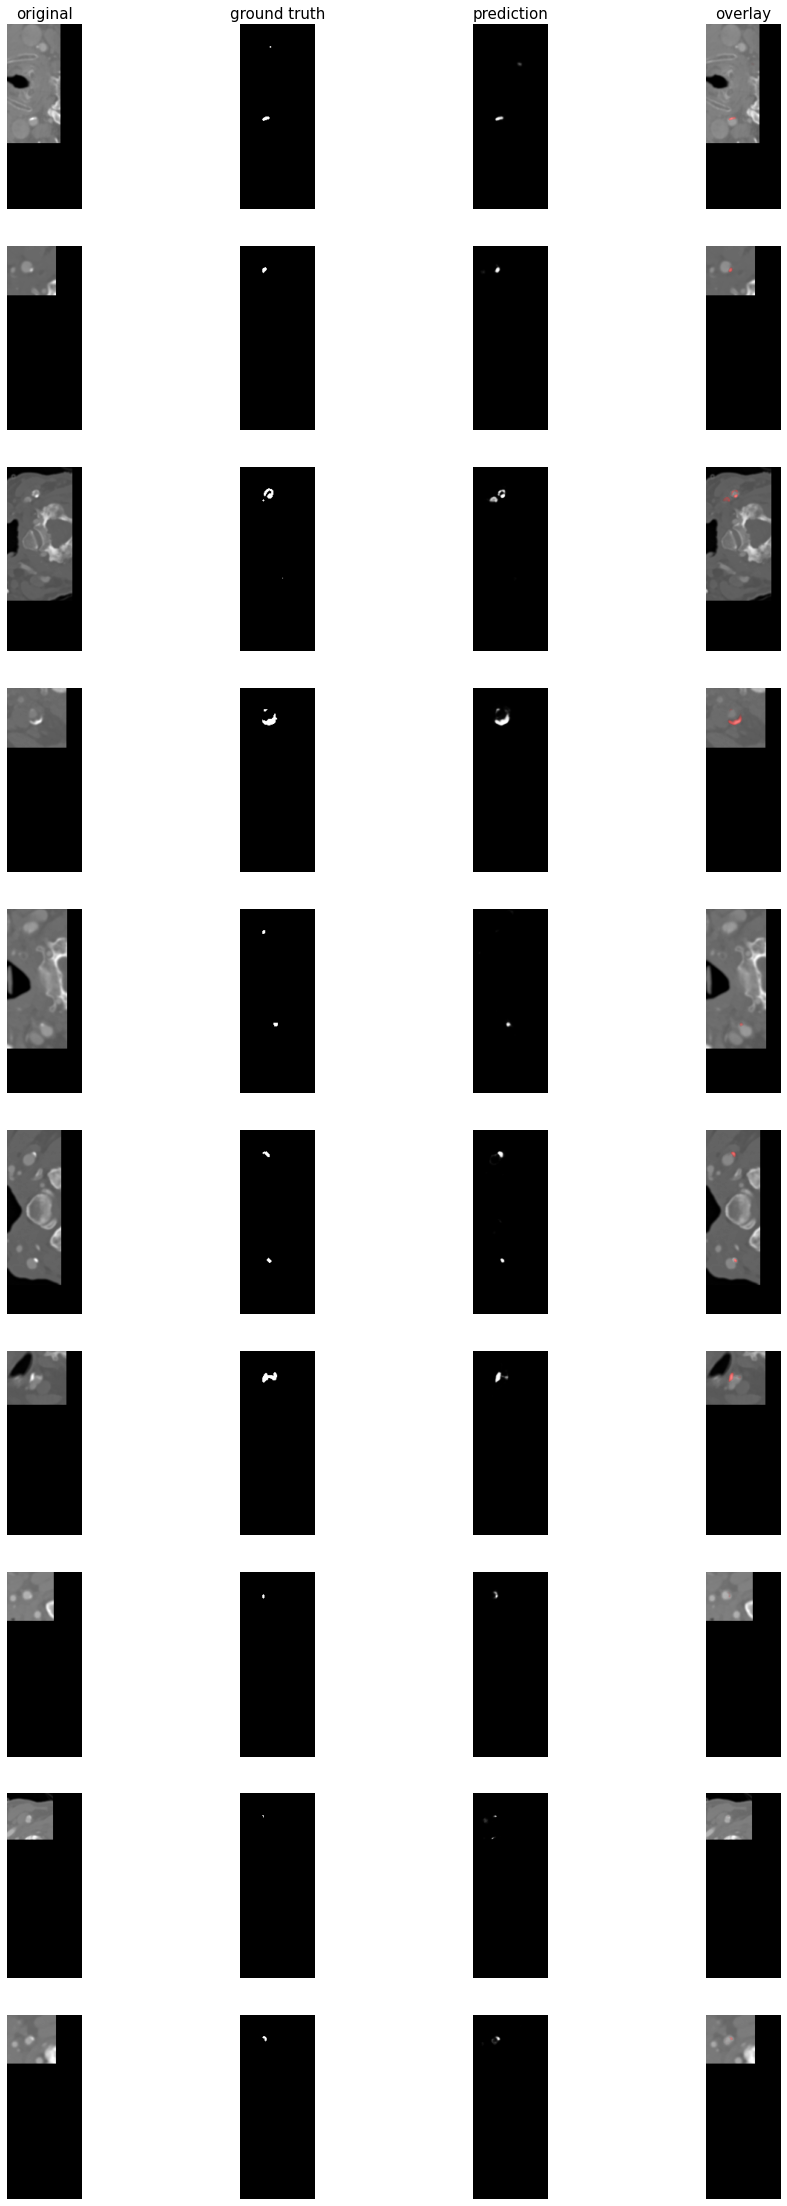

In [36]:
plot_imgs(org_imgs=X_test_c_np, mask_imgs=y_test_c_np, pred_imgs=y_pred_c_np)